In [1]:
pip install spacy_transformers --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install -U spacy --quiet

In [3]:
pip --version

pip 23.2.1 from /Users/bellagracefinck/anaconda3/lib/python3.11/site-packages/pip (python 3.11)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from io import StringIO
from bs4 import BeautifulSoup as bs
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize, WhitespaceTokenizer, TweetTokenizer

In [3]:
designers = pd.read_csv('designers.csv').drop(columns = 'Unnamed: 0')
designers.head(2)

,designer,collections,first_season,consistency,prevalence,class
0,comme-des-garcons,65,1991.0,0.984848,0.969464,5
1,versace,61,1991.0,0.924242,0.907849,4


In [4]:
collections = pd.read_csv('collections.csv').drop(columns = 'Unnamed: 0')
collections.head(2)

,season,year,seasonyear,designer,text,id,preprocessed_sentences,consistency,prevalence,class
0,spring,1990,1990.0,azzedine-alaia,An enfilade of stretchy knits in jewel tones w...,0,enfilad stretchi knit jewel tone effect showma...,0.235294,0.172794,2
1,spring,1990,1990.0,romeo-gigli,Romeo Gigli is having a moment. The designer’s...,1,moment design signatur cocoon shape folder stu...,0.014706,-0.985294,0


In [5]:
train = pd.read_csv('word_labels.csv')
train['word'] = [word.lower() for word in train['word']]
train.head()

,word,label
0,alizarin,COLOR
1,amaranth,COLOR
2,amber,COLOR
3,amethyst,COLOR
4,apricot,COLOR


In [6]:
from nltk.stem import WordNetLemmatizer
import string
from gensim.parsing import preprocess_string 

lemmatizer = WordNetLemmatizer()

for word in train['word']:
    lem = lemmatizer.lemmatize(word)
    pre = preprocess_string(word)
    if lem != word:
        temp = pd.DataFrame([{'word': lem, 'label': list(train[train['word']==word]['label'])[0]}])
        train = pd.concat([train, temp], ignore_index=True)
    if pre != word:
        temp = pd.DataFrame([{'word': pre[0], 'label': list(train[train['word']==word]['label'])[0]}])
        train = pd.concat([train, temp], ignore_index=True)
        
train = train.drop_duplicates('word')

In [7]:
grouped_labels = train.groupby('label')['word'].apply(list).to_dict()

## Named Entity Recognition
For this project, I decided to create my own rudimentary NER model that is tailored (no pun intended) specifically to identify attributes of fashion collections. This model is not extensive by any means, but it provides a good starting place for my research in tracking trends.

I have two versions of this - one spacy model that is a work in progress (it will occasionally throw errors randomly) and a simpler version that manually annotates the data based on the NER labels. 

In [10]:
import spacy
from spacy.language import Language
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span

nlp = spacy.load("en_core_web_sm", disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"])


# Create patterns for each label
label_patterns = {label: list(nlp.pipe(words)) for label, words in grouped_labels.items()}

# Initialize PhraseMatcher
matcher = PhraseMatcher(nlp.vocab)
for label, patterns in label_patterns.items():
    matcher.add(label, patterns)

# Define the custom component for fashion term labeling
@Language.component("fashion_component")
def fashion_component_function(doc):
    # Apply the matcher to the doc
    matches = matcher(doc)
    # Create a Span for each match and assign the label to the span
    spans = [Span(doc, start, end, label=label) for label, start, end in matches]
    # Overwrite the doc.ents with the matched spans
    doc.ents = spans
    return doc

# Add the fashion component to the SpaCy pipeline after the "ner" component
nlp.add_pipe("fashion_component", after="ner")

# Process the text and print the text and label for the doc.ents
review = collections['preprocessed_sentences'][2]
raw = collections['text'][2]
doc = nlp(review)
print(raw, '\n', [(ent.text, ent.label_) for ent in doc.ents])

/Users/bellagracefinck/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Alaïa worked with pinstripes and other power materials this season. His timing was spot-on; the recession was starting to lift. While some of his sexy suiting would certainly work in a boardroom setting, the bedroom seemed the final destination for some of his lacy evening looks.</p></div> 
 [('pinstrip', 'FEATURE'), ('suit', 'GARMENT_TYPE'), ('laci', 'MATERIAL'), ('even', 'FEATURE')]


In [8]:
# Manual data annotation
import time
start = time.time()
TRAIN_DATA = []
for review in collections['preprocessed_sentences']:
    #print('\n', review)
    tokens = word_tokenize(review)
    labels = {'entities':[]}
    idx = 0
    for token in tokens:
        idx += len(token) + 1
        if token in train['word'].values:
            start_idx = idx - len(token) - 1
            end_idx = idx - 1
            label = list(train[train['word']==token]['label'])[0]
            labels['entities'].append((token, start_idx, end_idx, label))
    TRAIN_DATA.append((review, labels))

end = time.time() 
print(end-start)
len(TRAIN_DATA)

84.92809414863586


14261

In [9]:
TRAIN_DATA[0]

('enfilad stretchi knit jewel tone effect showmanship real new spring combo tailor stretch fabric refer todai athleisur touch includ fit stori april issu photograph look like beach readi look fact wear bodi suit look like bath suit meant water splashi style nonetheless',
 {'entities': [('stretchi', 8, 16, 'FEATURE'),
   ('knit', 17, 21, 'FEATURE'),
   ('tailor', 74, 80, 'FEATURE'),
   ('fit', 131, 134, 'FEATURE'),
   ('suit', 205, 209, 'GARMENT_TYPE'),
   ('suit', 225, 229, 'GARMENT_TYPE')]})

In [159]:
# create columns of fashion words and word types in collections df
descriptors = []
types = []
for i in range(len(collections['id'])):
    words = []
    word_types = []
    for x in range(len(TRAIN_DATA[i][1]['entities'])):
        #if TRAIN_DATA[i][1]['entities'][x][3] != 'GARMENT_TYPE':
            words.append(TRAIN_DATA[i][1]['entities'][x][0])
            word_types.append(TRAIN_DATA[i][1]['entities'][x][3])
    descriptors.append(words)
    types.append(word_types)
    
collections['descriptors'] = descriptors
collections['labels'] = types

In [160]:
collections.head()

,season,year,seasonyear,designer,text,id,preprocessed_sentences,consistency,prevalence,class,descriptors,labels,extract
0,spring,1990,1990.0,azzedine-alaia,An enfilade of stretchy knits in jewel tones w...,0,enfilad stretchi knit jewel tone effect showma...,0.235294,0.172794,2,"[stretchi, knit, tailor, fit, suit, suit]","[FEATURE, FEATURE, FEATURE, FEATURE, GARMENT_T...",stretchi knit tailor fit
1,spring,1990,1990.0,romeo-gigli,Romeo Gigli is having a moment. The designer’s...,1,moment design signatur cocoon shape folder stu...,0.014706,-0.985294,0,"[skirt, dramat, cape, non, straight, line, fel...","[GARMENT_TYPE, STYLE, GARMENT_TYPE, FEATURE, F...",dramat non straight line felt drape
2,fall,1990,1990.1,azzedine-alaia,Alaïa worked with pinstripes and other power m...,2,work pinstrip power materi season time spot re...,0.235294,0.172794,2,"[pinstrip, suit, laci, even]","[FEATURE, GARMENT_TYPE, MATERIAL, FEATURE]",pinstrip laci even
3,spring,1991,1991.0,azzedine-alaia,"<a href=""https://www.vogue.com/article/bella-h...",3,hadid remind follow timeless appeal april appe...,0.235294,0.172794,2,"[high, street, houndstooth, print, knit, denim...","[FEATURE, STYLE, MATERIAL, FEATURE, FEATURE, M...",high street houndstooth print knit denim short
4,spring,1991,1991.0,comme-des-garcons,"“Comme des Garçons,” Rei Kawakubo told <em>Vog...",4,told gift oneself appeal attract opposit sex s...,0.984848,0.969464,5,"[sheer, lingeri, silk, drape, jersei, rose, fl...","[FEATURE, GARMENT_TYPE, MATERIAL, FEATURE, MAT...",sheer silk drape jersei rose flamboy textur pa...


In [162]:
# save word labels to updated .csv file
train.to_csv('word_labels_updated.csv')

### Analyzing word frequency across seasons

In [12]:
#' '.join([words[i] for word in ])
sample_tokens = (collections[['id','year','descriptors']].explode('descriptors'))
data = sample_tokens.fillna('drop')
data = data[data['descriptors']!= 'drop']
sample_tokens

sample_tokens[sample_tokens['year'] > 1990]['descriptors'].value_counts()

descriptors
print       9267
leather     5685
silk        4760
knit        4463
tailor      3724
            ... 
amaranth       1
tussah         1
batist         1
zucchini       1
shamrock       1
Name: count, Length: 425, dtype: int64

In [16]:
from wordcloud import WordCloud
def make_wc(startyear, endyear):
    subset = collections[collections['year']>=startyear]
    subset = collections[collections['year']<=endyear]
    
    sample_tokens = (subset[['id','descriptors']].explode('descriptors'))
    data = sample_tokens.fillna('drop')
    data = data[data['descriptors']!= 'drop']
    wc = WordCloud(background_color="white", max_font_size= 300,  width=1600, height=800).generate(' '.join(data['descriptors']))

    plt.figure(figsize=(20,20))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

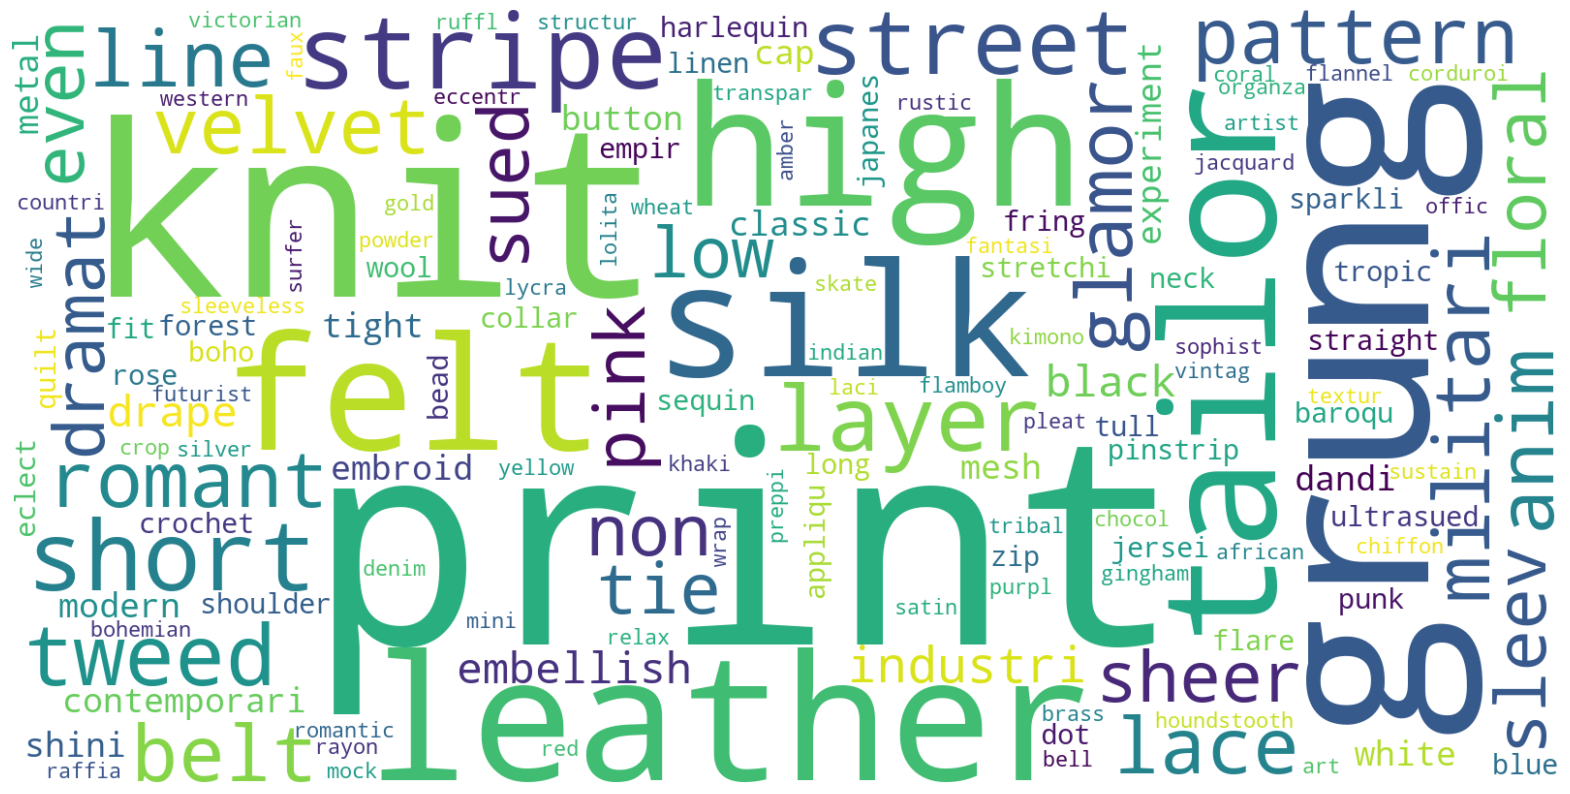

In [17]:
make_wc(1990, 1994)

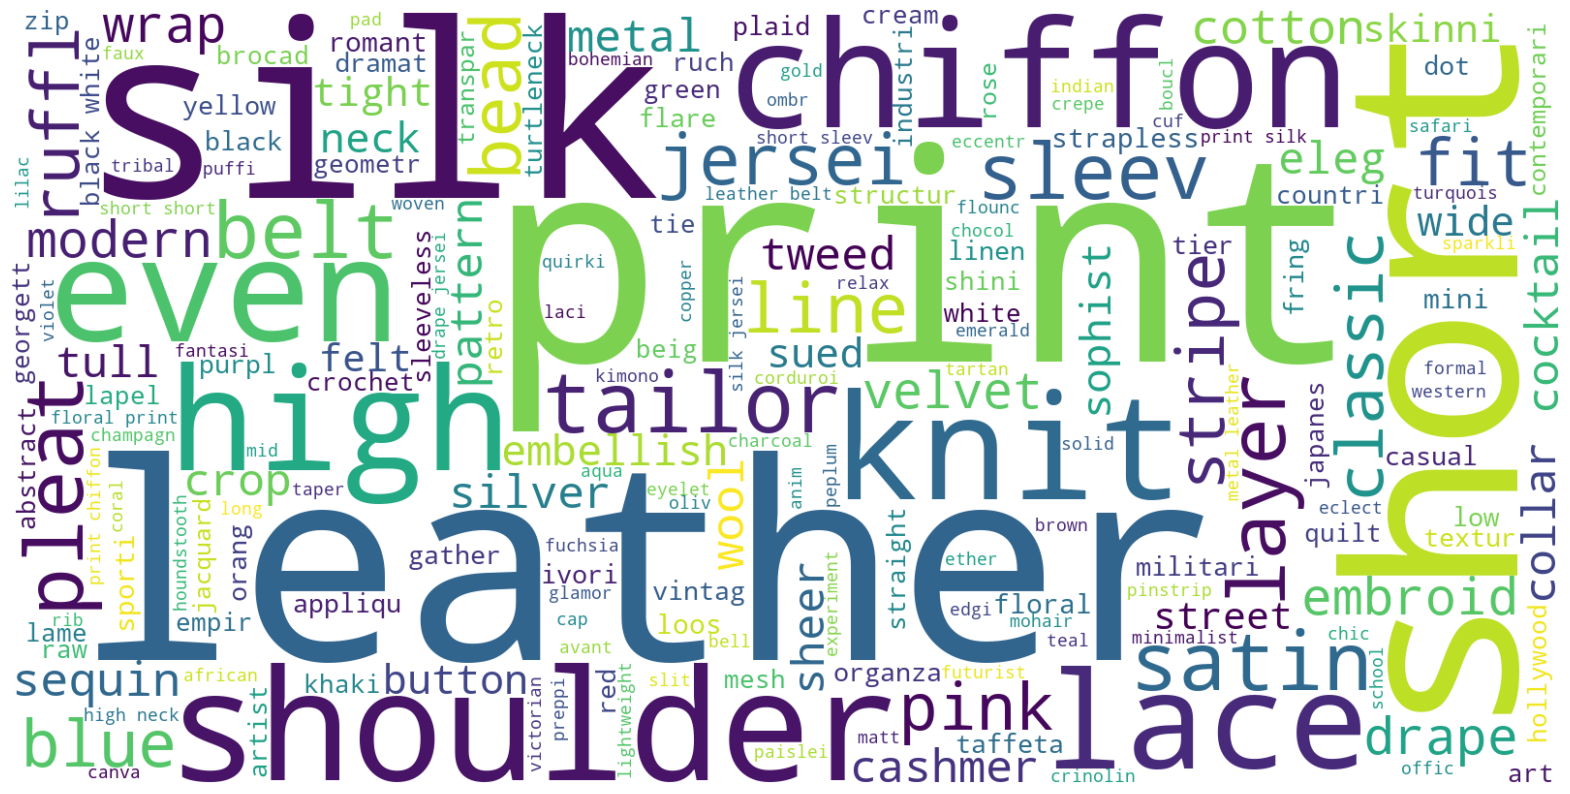

In [19]:
make_wc(2000, 2009)

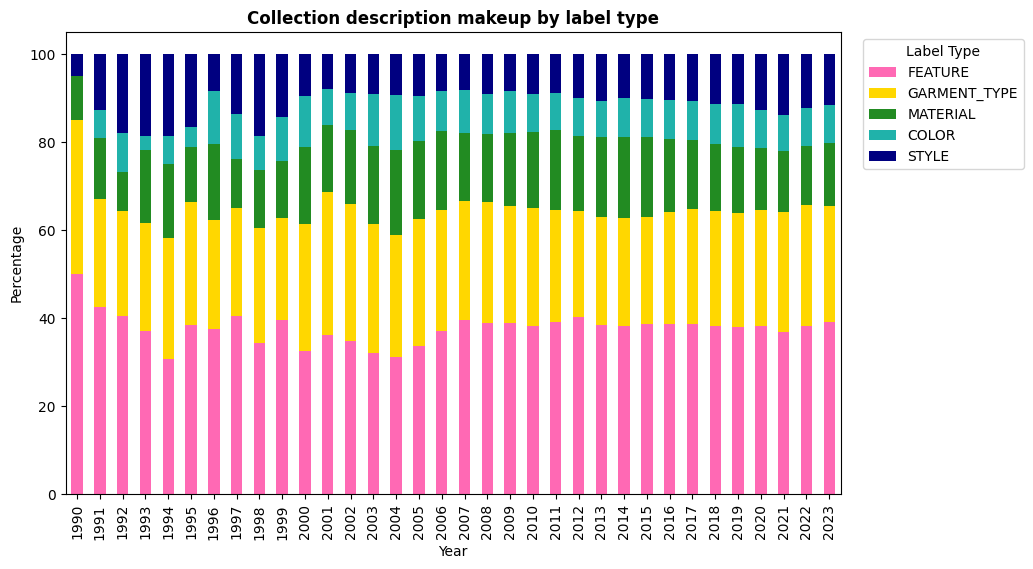

In [196]:
label_counts_df = pd.DataFrame()
palette = sns.color_palette(["hotpink", "gold", "forestgreen", "lightseagreen", "navy"])

# Iterate over each label type
for label_type in ['FEATURE', 'GARMENT_TYPE', 'MATERIAL', 'COLOR', 'STYLE']:
    # Create a new column for each label type with the count of occurrences
    label_counts_df[label_type] = collections['labels'].apply(lambda x: x.count(label_type))

# Add the 'year' column to the label_counts_df
label_counts_df['year'] = collections['year']

# Group by year and calculate the sum of each label type
label_counts_by_year = label_counts_df.groupby('year').sum()

# Calculate the percentage of each label type for each year
label_percentages_by_year = label_counts_by_year.div(label_counts_by_year.sum(axis=1), axis=0) * 100

# Plot the percentages
label_percentages_by_year.plot(kind='bar', stacked=True, figsize=(10, 6), color=palette)
plt.title('Collection description makeup by label type', fontdict = {'fontweight':'bold'})
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(title='Label Type', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()

## K-means clustering on fashion characteristics to identify similar collections and years in fashion (trend cycle)

In [23]:
collections['extract'] = [' '.join(collection) for collection in collections['descriptors']]

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize, WhitespaceTokenizer, TweetTokenizer
# random sample of 4000 collections
subset = collections.sample(5000, random_state = 1)
X = subset['extract']
y = subset['year']
ids = X.index

In [25]:
tfidf = TfidfVectorizer(ngram_range=(1,1)).fit(X)
X_transformed = tfidf.transform(X)

In [26]:
# Clustering the training sentences with K-means technique
run_dict = {}
from sklearn.cluster import KMeans
for i in range(50):
    km = KMeans(n_clusters=50, init='k-means++', n_init ='auto', random_state = i)
    km.fit(X_transformed)
    run_dict[i]=dict(zip(ids,km.labels_))

In [27]:
from collections import Counter
Counter(list(run_dict[5].values()))
run_dict[5]

{13938: 43,
 10629: 35,
 3579: 34,
 2223: 39,
 3516: 1,
 13991: 21,
 6456: 42,
 11145: 0,
 11082: 14,
 7120: 38,
 12801: 28,
 7497: 45,
 10218: 22,
 9059: 15,
 3985: 7,
 10087: 11,
 6075: 44,
 3525: 23,
 1060: 19,
 13666: 2,
 7508: 1,
 11383: 9,
 6160: 12,
 10861: 31,
 13612: 44,
 2391: 0,
 7784: 49,
 2987: 49,
 12425: 41,
 8477: 34,
 1277: 24,
 335: 7,
 12732: 26,
 2863: 21,
 12862: 35,
 13008: 33,
 1156: 12,
 11078: 8,
 6573: 41,
 3448: 31,
 6454: 34,
 5619: 5,
 8426: 15,
 3592: 28,
 4097: 22,
 6950: 44,
 5644: 46,
 5526: 33,
 4744: 17,
 13637: 21,
 1749: 1,
 13003: 37,
 13780: 33,
 3644: 30,
 32: 6,
 6077: 37,
 1892: 23,
 1292: 36,
 8761: 28,
 9579: 19,
 12762: 6,
 13046: 16,
 2087: 23,
 14155: 8,
 1684: 5,
 5877: 32,
 13739: 30,
 644: 28,
 5402: 3,
 551: 25,
 10977: 5,
 153: 41,
 8122: 47,
 2795: 18,
 7609: 25,
 8655: 0,
 4325: 37,
 4403: 44,
 4576: 22,
 1537: 38,
 13531: 44,
 9354: 47,
 4822: 6,
 7935: 48,
 10796: 48,
 7082: 43,
 12369: 4,
 8402: 30,
 3832: 40,
 10662: 9,
 13181: 

In [28]:
# creation of frequency table
rows = dict()
start = time.time()
for coll_id in ids:
    row = dict()
    for run in run_dict:
        cluster = run_dict[run][coll_id]
        for other in run_dict[run]:
            if run_dict[run][other]==cluster:
                if other in row.keys():
                    row[other] += 1
                else:
                    row[other] = 1
            elif run_dict[run][other]!=cluster:
                if other in row.keys():
                    row[other] += 0
                else:
                    row[other] = 0

    rows[coll_id] = row
end = time.time()
print(end-start)

# Creation of the dataframe
freq = pd.DataFrame.from_dict(rows, orient='index')

477.5102598667145


In [29]:
freq

,13938,10629,3579,2223,3516,13991,6456,11145,11082,7120,...,14097,9763,7240,4520,14053,4150,12535,3529,3821,2870
13938,50,0,0,0,2,7,0,0,0,1,...,0,0,2,1,1,0,2,1,0,1
10629,0,50,0,0,0,0,0,0,0,0,...,2,1,0,0,3,0,0,0,0,0
3579,0,0,50,0,3,0,2,11,0,0,...,0,0,1,0,2,0,1,1,2,1
2223,0,0,0,50,2,0,10,0,3,0,...,0,0,5,7,2,0,1,4,0,15
3516,2,0,3,2,50,0,3,3,0,0,...,0,0,4,3,6,0,6,7,7,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4150,0,0,0,0,0,4,0,25,0,0,...,0,2,6,0,0,50,0,0,1,0
12535,2,0,1,1,6,1,0,0,0,0,...,0,0,2,0,4,0,50,3,2,2
3529,1,0,1,4,7,0,2,0,0,0,...,0,0,5,1,2,0,3,50,3,3
3821,0,0,2,0,7,0,1,0,0,30,...,2,3,0,0,4,1,2,3,50,5


In [30]:
freq.to_csv('freq_5000.csv')

In [ ]:
# 2000 collection sample - 59.201 seconds
# 5000 collection sample - 348.736 seconds

In [16]:
#freq = pd.read_csv('freq_5000.csv', index_col=[0]) # read in file if kernel resets

In [31]:
for i in range(25):
    freq = freq.replace(i, 0)
freq

,13938,10629,3579,2223,3516,13991,6456,11145,11082,7120,...,14097,9763,7240,4520,14053,4150,12535,3529,3821,2870
13938,50,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10629,0,50,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3579,0,0,50,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2223,0,0,0,50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3516,0,0,0,0,50,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4150,0,0,0,0,0,0,0,25,0,0,...,0,0,0,0,0,50,0,0,0,0
12535,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,50,0,0,0
3529,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,50,0,0
3821,0,0,0,0,0,0,0,0,0,30,...,0,0,0,0,0,0,0,0,50,0


In [32]:
import networkx as nx

G = nx.from_pandas_adjacency(freq)
G.name = "Graph from pandas adjacency matrix"
print(G)

Graph named 'Graph from pandas adjacency matrix' with 5000 nodes and 120502 edges


In [33]:
# remove self loops (values along the diagonal)
G.remove_edges_from(nx.selfloop_edges(G))

In [52]:
attrs = {}
for name in collections['id']:
    designer = list(collections[collections['id']==name]['designer'])[0]
    sy = list(collections[collections['id']==name]['seasonyear'])[0]
    classs = list(collections[collections['id']==name]['class'])[0]
    attrs[name] = {'designer': designer, 'seasonyear': sy, 'class':classs}

In [53]:
name_dict = dict(zip(collections['id'], collections['designer']))
season_dict =  dict(zip(collections['id'], collections['seasonyear']))
nx.set_node_attributes(G, attrs)

In [54]:
nx.write_gexf(G, 'freq_5000.gexf')

In [55]:
groups = nx.community.greedy_modularity_communities(G)

len(groups)

707

In [56]:
# some groups are made up of singleton collections that did not end up in a community
# some groups are made up of a ton of collections (len(group) = 828, 463, etc.)
Counter([len(group) for group in groups])

Counter({1: 664,
         2: 12,
         3: 3,
         55: 2,
         4: 2,
         828: 1,
         463: 1,
         270: 1,
         253: 1,
         206: 1,
         195: 1,
         192: 1,
         173: 1,
         147: 1,
         142: 1,
         141: 1,
         135: 1,
         126: 1,
         125: 1,
         120: 1,
         117: 1,
         111: 1,
         100: 1,
         85: 1,
         82: 1,
         73: 1,
         57: 1,
         36: 1,
         8: 1})

In [62]:
word_labels = train[train['label']!='GARMENT_TYPE']

from sklearn import preprocessing
def tfidf(tokens):
    # create a word frequency dataframe
    term_frequency = (tokens
                      .groupby(by=['id', 'tokens'])
                      .agg({'tokens': 'count'})
                      .rename(columns={'tokens': 'term_frequency'})
                      .reset_index()
                      .rename(columns={'tokens': 'term'}))
    
    document_frequency = (term_frequency
                      .groupby(['id', 'term'])
                      .size()
                      .unstack()
                      .sum()
                      .reset_index()
                      .rename(columns={0: 'document_frequency'}))

    # merge dataframes
    term_frequency = term_frequency.merge(document_frequency)

    documents_in_corpus = term_frequency['id'].nunique()

    term_frequency['idf'] = np.log((1 + documents_in_corpus) / (1 + term_frequency['document_frequency'])) + 1
    term_frequency['tfidf'] = term_frequency['term_frequency'] * term_frequency['idf']
    
    term_frequency['tfidf_norm'] = preprocessing.normalize(term_frequency[['tfidf']], axis=0, norm='l2')

    return term_frequency.sort_values(by=['tfidf_norm'], ascending=False).groupby(['term']).head()

In [63]:
medium_groups = [group for group in groups if len(group) > 3 and len(group) < 400]

In [207]:
indices = medium_groups[12]
collections[collections['id'].isin(indices)].describe()
subset = collections[collections['id'].isin(indices)].copy()

subset['tokens'] = [word_tokenize(' '.join(sentence)) for sentence in subset['descriptors']]
sample_tokens = (subset[['id','tokens']].explode('tokens'))
sample_tokens = sample_tokens[sample_tokens['tokens'].isin(train['word'])]

output = tfidf(sample_tokens).groupby('term').agg({
    'term_frequency': 'mean',  
    'document_frequency': 'mean',  
    'idf': 'max',  
    'tfidf': 'mean', 
    'tfidf_norm': 'mean'  
}).reset_index()
output.columns = ['term', 'avg_term_frequency', 'document_frequency', 'idf', 'tfidf',
       'tfidf_norm']
print('Sample 1')
output.sort_values('tfidf_norm', ascending = False).head(10)[['term', 'tfidf_norm']]

Sample 1


,term,tfidf_norm
235,shibori,0.057527
294,upcycl,0.057527
210,raffia,0.057527
254,steel,0.057527
40,cardin,0.057527
237,shirt,0.053153
180,paislei,0.052949
25,bra,0.047180
133,knit,0.043509
173,offic,0.041283


In [208]:
indices = medium_groups[16]
collections[collections['id'].isin(indices)].describe()
subset = collections[collections['id'].isin(indices)].copy()

subset['tokens'] = [word_tokenize(' '.join(sentence)) for sentence in subset['descriptors']]
sample_tokens = (subset[['id','tokens']].explode('tokens'))
sample_tokens = sample_tokens[sample_tokens['tokens'].isin(train['word'])]

output = tfidf(sample_tokens).groupby('term').agg({
    'term_frequency': 'mean',  
    'document_frequency': 'mean',  
    'idf': 'max',  
    'tfidf': 'mean', 
    'tfidf_norm': 'mean'  
}).reset_index()
output.columns = ['term', 'avg_term_frequency', 'document_frequency', 'idf', 'tfidf',
       'tfidf_norm']
print('Sample 2')
output.sort_values('tfidf_norm', ascending = False).head(10)[['term', 'tfidf_norm']]

Sample 2


,term,tfidf_norm
207,robe,0.072994
67,dandi,0.063875
283,western,0.063875
196,punk,0.063875
170,offic,0.058395
290,zip,0.054506
253,sweater,0.046333
131,lace,0.046333
133,lame,0.045422
59,countri,0.045054


In [209]:
indices = medium_groups[20]
collections[collections['id'].isin(indices)].describe()
subset = collections[collections['id'].isin(indices)].copy()

subset['tokens'] = [word_tokenize(' '.join(sentence)) for sentence in subset['descriptors']]
sample_tokens = (subset[['id','tokens']].explode('tokens'))
sample_tokens = sample_tokens[sample_tokens['tokens'].isin(train['word'])]

output = tfidf(sample_tokens).groupby('term').agg({
    'term_frequency': 'mean',  
    'document_frequency': 'mean',  
    'idf': 'max',  
    'tfidf': 'mean', 
    'tfidf_norm': 'mean'  
}).reset_index()
output.columns = ['term', 'avg_term_frequency', 'document_frequency', 'idf', 'tfidf',
       'tfidf_norm']
print('Sample 3')
output.sort_values('tfidf_norm', ascending = False).head(10)[['term', 'tfidf_norm']]

Sample 3


,term,tfidf_norm
134,minimalist,0.078059
83,gauz,0.078059
210,sustain,0.078059
157,piqu,0.078059
209,suit,0.069005
188,short,0.055896
121,linen,0.054642
163,print,0.054133
221,tie,0.053856
1,anim,0.053065


In [210]:
indices = medium_groups[15]

collections[collections['id'].isin(indices)].describe()
subset = collections[collections['id'].isin(indices)].copy()

subset['tokens'] = [word_tokenize(' '.join(sentence)) for sentence in subset['descriptors']]
sample_tokens = (subset[['id','tokens']].explode('tokens'))
sample_tokens = sample_tokens[sample_tokens['tokens'].isin(train['word'])]

output = tfidf(sample_tokens).groupby('term').agg({
    'term_frequency': 'mean',  
    'document_frequency': 'mean',  
    'idf': 'max',  
    'tfidf': 'mean', 
    'tfidf_norm': 'mean'  
}).reset_index()
output.columns = ['term', 'avg_term_frequency', 'document_frequency', 'idf', 'tfidf',
       'tfidf_norm']
print('Sample 4')
output.sort_values('tfidf_norm', ascending = False).head(10)[['term', 'tfidf_norm']]

Sample 4


,term,tfidf_norm
4,aqua,0.084732
201,rib,0.061629
216,sci,0.061629
243,stretchi,0.061629
247,sued,0.061629
276,upcycl,0.050011
250,sustain,0.045476
114,indian,0.042366
249,surreal,0.042366
97,futurist,0.042366


## Recurrent Neural Network: Predicting designer prevalence

In [70]:
import tensorflow as tf

In [83]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

X = collections[['designer','season','preprocessed_sentences']]
y = [0 if x != 5 else 1 for x in collections['class']]

In [84]:
from sklearn.model_selection import train_test_split
train_ratio = 0.7
validation_ratio = 0.2
test_ratio = 0.1

X_train, X_test, y_train, y_test = train_test_split(X['preprocessed_sentences'], y, test_size=1 - train_ratio, random_state=42, stratify = y)

X_val, x_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42, stratify = y_test)

print(f'Training samples: {len(X_train)}')
print(f'Validation samples: {len(X_val)}')

Training samples: 9982
Validation samples: 2852


In [85]:
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens= 28746, output_sequence_length= 150)

# Adapt the text vectorizer to the training data
text_vectorizer.adapt(X_train)

In [86]:
# examine the vocabulary
vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in the vocabulary: {len(vocab)}')
print(f'Most common words in the vocabulary: {vocab[:5]}')
print(f'Least common words in the vocabulary: {vocab[-5:]}')

Number of words in the vocabulary: 28709
Most common words in the vocabulary: ['', '[UNK]', 'look', 'like', 'dress']
Least common words in the vocabulary: ['aaronel', 'aaliyah', 'aaah', 'aaaargh', 'aaaaaaaah']


In [87]:
token_embedding = tf.keras.layers.Embedding(input_dim=len(vocab),
                                            output_dim=128,
                                            mask_zero=True,
                                            name='token_embedding')

# Randomly visualize some of your vectorized textual data
import random
example_sent = random.choice(X_train.values) # change var name if you need to
print(f'Sentence before vectorization: {example_sent}')
vectorized_sent = text_vectorizer(example_sent)
print(f'Sentence after vectorization: {vectorized_sent}')
embedded_sent = token_embedding(vectorized_sent)
print(f'Sentence after embedding: {embedded_sent}')

Sentence before vectorization: femal voic repeat runwai autom machin ag ring descript worker lab technician press releas hint primaci inexplic fire synaps decid like tradit pink damask minut oatmeal sweater plasticki holograph fabric pointi strappi heel decor strip spongi foam shacklewel lane week discuss deputi director particularli felt like make statement girl season enjoi spontan choos shape fabric blob jag edg thing float mind languag far remov autobiograph insight scottish cathol high upbring given recent loosei goosei execut damask gainsborough silk woven england appli furnish graphic precis cut neat coat skirt dress shot taffeta peacock blue roomi shoulder wave coat match shirt whoosh sunrai pleat skirt signatur improvis ey took pick haberdasheri sequin drop patch pocket plain cotton drill line skirt beig raincoat scatter paillett embroid chiffon effect lot varieti edgi glamour industri aura spaceship print stori prove reproduct work outsid artist ionel talpazan product kind na

In [88]:
X_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val))

In [89]:
for sample in X_dataset.take(2):
    review, label = sample
    print(f'Review: {review} - Prevalence: {label}')

Review: b'subdu sure true basic attitud sweep abandon freaki makeup vertigin footwear season past turn fall readi wear exhaust commerci workout collect mod sixti vibe right romant empir look start black white stripe ladder edi mohair knit worn baker boi cap flat pointi crocodil knee boot fishnet quickli devic show stapl jacket brought parti cutawai tail coat biker jacket napoleon collar reinterpret semin look bar jacket segu shearl aviat crocodil leather send high belt maxi coat knowingli check box season trend sheet gorgeou russet dusti pink burnt orang velvet follow dress silver grai delic pink grape distil rococo delicaci believ partywear heavili underscor cash valu wearabl classic ad willfulli obscur year appar insan experiment accur pictur readi wear wait glimps go' - Prevalence: 1
Review: b'japan exclaim vintag dealer easi backstag said focus innoc sensual qualiti plai big asian presenc larger girli frilli plai home time look diaphan babi doll lace trim set mood lingeri inspir lo

2024-05-13 09:48:19.128975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [90]:
BATCH_SIZE = 32
BUFFER_SIZE = 10_000

In [91]:
train_dataset = X_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# MODEL Hyperparameters
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
loss = 'sparse_categorical_crossentropy'
epochs = 5

In [110]:
# Build RNN model

from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import TextVectorization, Bidirectional, LSTM, Dropout, Dense

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)

x = tf.keras.layers.Embedding(input_dim=len(vocab), output_dim=128, mask_zero=True)(x)
x = Dropout(0.5)(x)
x = tf.keras.layers.LSTM(100)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='sigmoid')(x)
outputs = layers.Dense(len(Counter(y).keys()), activation='softmax')(x)


# model creation
model = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [111]:
# Train the model or fit the model on the data
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 45s 139ms/step - accuracy: 0.7363 - loss: 0.5818 - val_accuracy: 0.7335 - val_loss: 0.5795
Epoch 2/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 47s 151ms/step - accuracy: 0.7297 - loss: 0.5834 - val_accuracy: 0.7335 - val_loss: 0.5806
Epoch 3/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 47s 151ms/step - accuracy: 0.7243 - loss: 0.5772 - val_accuracy: 0.7335 - val_loss: 0.5516
Epoch 4/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 45s 145ms/step - accuracy: 0.7597 - loss: 0.4787 - val_accuracy: 0.7079 - val_loss: 0.5578
Epoch 5/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 43s 137ms/step - accuracy: 0.8658 - loss: 0.3172 - val_accuracy: 0.7118 - val_loss: 0.5841


In [112]:
# plot the training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

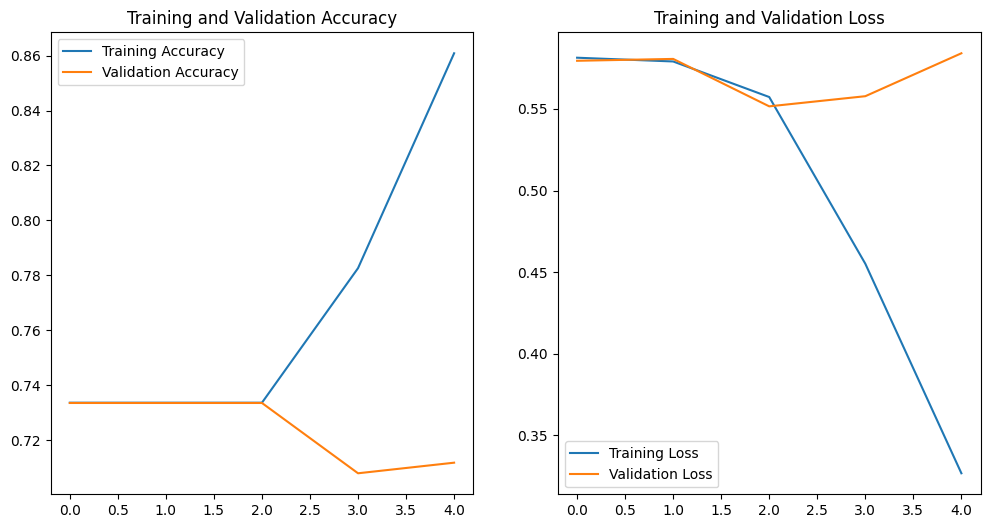

In [113]:
plot_history(history)

## Naive-Bayes model to see which attributes (fashion-related words) featured in the collections were the most informative to the predictions

In [114]:
len(train['word'].unique())

805

In [115]:
X = collections[['designer','season','descriptors']].copy()
X['descriptors'] = [' '.join(lis) for lis in X['descriptors']]
y = [0 if x != 5 else 1 for x in collections['class']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, stratify = y)

In [116]:
bow = CountVectorizer(stop_words = None, preprocessor = None, tokenizer = word_tokenize,
                      ngram_range=(1,1), max_features = 805, max_df = 1.0, min_df = 1, binary = False)
training_data = bow.fit_transform(X_train['descriptors'])
test_data = bow.transform(X_test['descriptors'])

/Users/bellagracefinck/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [117]:
dftrain = pd.DataFrame(training_data.toarray())
dftrain.columns = bow.get_feature_names_out()
dftest = pd.DataFrame(test_data.toarray())
dftest.columns = bow.get_feature_names_out()
dftrain.shape

dftrain

,abstract,african,amber,amethyst,anim,appliqu,apricot,aqua,aquamarin,art,...,wheat,whimsic,white,wide,wisteria,wool,woven,wrap,yellow,zip
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8551,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8553,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
8554,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
clf = MultinomialNB(alpha = 0.71)
model = clf.fit(dftrain, y_train)
preds = model.predict(dftest)
accuracy = accuracy_score(y_test, preds)
print('accuracy: ', accuracy)

accuracy:  0.7211218229623138


In [135]:
# Extract top informative words and their coefficients
log_probabilities = model.feature_log_prob_
target_class_log_probabilities = log_probabilities[1]
feature_names = bow.get_feature_names_out()
word_log_probabilities = dict(zip(feature_names, target_class_log_probabilities))
sorted_words = sorted(word_log_probabilities.items(), key=lambda x: x[1], reverse=True)

top_words_count = 20  
top_informative_words = pd.DataFrame(columns=['Top designers (Class 1)', 'Coefficient for Class 1',
                                               'Normal designers (Class 0)', 'Coefficient for Class 0'])
for i in range(top_words_count):
    word_class_1, log_prob_class_1 = sorted_words[i]
    word_class_0, log_prob_class_0 = sorted_words[-(i+1)]
    top_informative_words = pd.concat([top_informative_words,
                                        pd.DataFrame({'Top designers (Class 1)': [word_class_1],
                                                      'Coefficient for Class 1': [log_prob_class_1],
                                                      'Normal designers (Class 0)': [word_class_0],
                                                      'Coefficient for Class 0': [log_prob_class_0]})],
                                       ignore_index=True)

top_informative_words

,Top designers (Class 1),Coefficient for Class 1,Normal designers (Class 0),Coefficient for Class 0
0,print,-3.245263,viridian,-10.845962
1,leather,-3.687053,velveteen,-10.845962
2,silk,-3.839432,tussah,-10.845962
3,knit,-3.854862,titanium,-10.845962
4,tailor,-3.980335,tencel,-10.845962
5,high,-4.013188,rami,-10.845962
6,lace,-4.016229,puce,-10.845962
7,shoulder,-4.051880,peter,-10.845962
8,sleev,-4.108694,pear,-10.845962
9,short,-4.168931,metallic,-10.845962
